# Finding exoplanets with Python + Lightkurve

Creación de datos sintéticos y modelo de Machine Learning

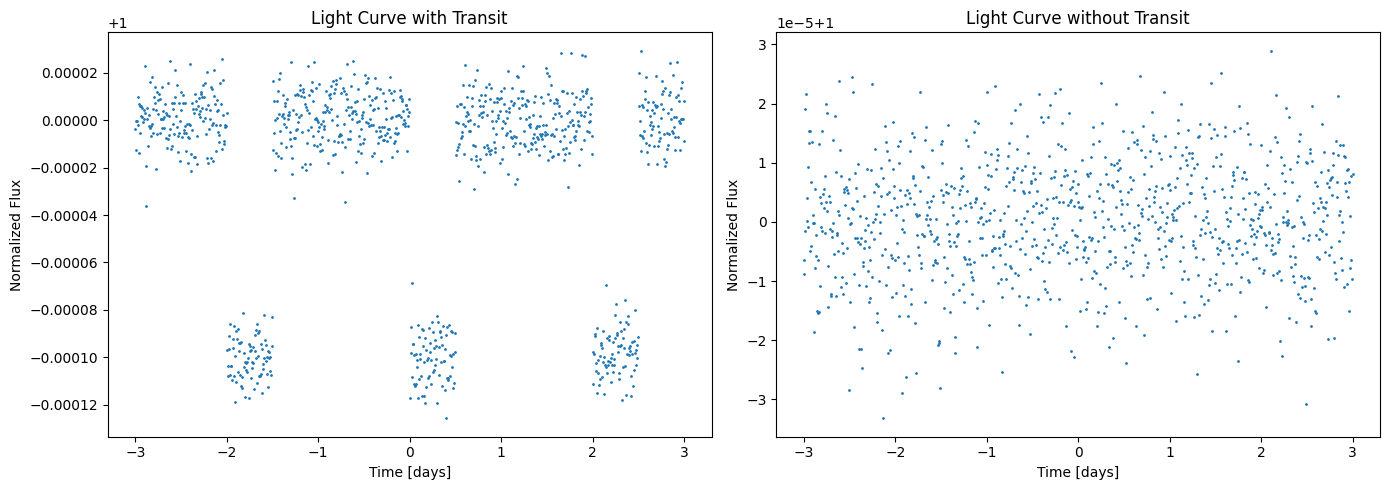

,Label,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,...,Time_990,Time_991,Time_992,Time_993,Time_994,Time_995,Time_996,Time_997,Time_998,Time_999
0,1.0,0.999996,1.000000,0.999988,1.000000,1.000010,0.999998,0.999986,1.000007,0.999995,...,1.000008,0.999988,0.999999,1.000014,1.000000,1.000001,1.000016,1.000001,0.999991,1.000008
1,1.0,1.000009,0.999997,1.000000,0.999989,1.000007,1.000009,0.999997,1.000012,1.000012,...,1.000004,0.999992,0.999995,1.000008,0.999971,1.000002,1.000005,1.000007,1.000017,1.000027
2,1.0,1.000024,1.000003,1.000002,0.999965,0.999998,1.000003,1.000000,1.000003,0.999999,...,0.999997,0.999992,1.000011,1.000006,0.999998,1.000000,0.999993,1.000008,0.999994,1.000009
3,1.0,0.999993,1.000006,1.000006,0.999995,1.000002,1.000012,1.000001,1.000004,0.999992,...,1.000022,1.000009,1.000018,1.000017,1.000002,1.000003,1.000001,1.000002,0.999987,0.999991
4,1.0,1.000009,0.999993,1.000008,1.000017,0.999996,1.000021,0.999986,1.000003,0.999989,...,0.999995,0.999979,0.999991,0.999997,0.999984,1.000001,1.000029,1.000013,1.000000,0.999999


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a synthetic dataset of light curves, 50% with a transit signal and 50% without.
num_points = 1000  # Number of data points for each light curve
num_curves = 500  # Number of light curves of each type

# Create time array for the light curves
time = np.linspace(-3, 3, num_points)

def generate_transit_curve(time, depth=0.0001, width=0.5, period=2):
    # Base signal with noise
    noise = np.random.normal(0, depth/10, size=time.shape)
    signal = np.ones_like(time) + noise
    # Subtract the transit depth at specific phases to simulate a transit
    for t in time:
        if -width < t % period < width:
            signal[np.where(time == t)] -= depth
    return signal

# Function to generate a light curve without a transit signal (only noise)
def generate_normal_curve(time, depth=0.0001):
    # Base signal with noise
    noise = np.random.normal(0, depth/10, size=time.shape)
    return np.ones_like(time) + noise

# Generate the transit and normal light curves
transit_curves = np.array([generate_transit_curve(time) for _ in range(num_curves)])
normal_curves = np.array([generate_normal_curve(time) for _ in range(num_curves)])
# Combine the transit and normal curves into a single array
all_curves = np.vstack((transit_curves, normal_curves))

# Generate labels for the curves, 1 for transit curves and 0 for normal curves
# First half of the labels will be 1 (for transit curves), and the second half will be 0 (for normal curves)
labels = np.concatenate((np.ones(num_curves), np.zeros(num_curves)))

# Combine the labels with the light curve data
# We want to add the labels as a new column, so we need to reshape the labels to be a 2D column vector
labels_column = labels.reshape(-1, 1)
labeled_data = np.hstack((labels_column, all_curves))

# Now, labeled_data is a single array with the labels in the first column
# and the light curve data in the subsequent columns

# Convert the array to a pandas DataFrame for easier manipulation and to add column names
column_names = ['Label'] + [f'Time_{i}' for i in range(num_points)]
labeled_df = pd.DataFrame(labeled_data, columns=column_names)




# Now let's plot the first light curve from each set
plt.figure(figsize=(14, 5))

# Plot the first transit light curve
plt.subplot(1, 2, 1)
plt.scatter(time, transit_curves[0], s=1)
plt.title('Light Curve with Transit')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Flux')

# Plot the first normal light curve
plt.subplot(1, 2, 2)
plt.scatter(time, normal_curves[0], s=1)
plt.title('Light Curve without Transit')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Flux')

plt.tight_layout()
plt.show()
# Display the first few rows of the DataFrame
labeled_df.head()


In [93]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import pandas as pd
X = labeled_df.drop('Label', axis=1)
y = labeled_df['Label']
# Dividir primero en entrenamiento y temporal (que será luego dividido en validación y prueba)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Ahora dividir el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Esto resulta en un 20% para cada uno
# Utilizar PCA en el conjunto de entrenamiento completo (ahora llamado X_train_temp)
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_temp)

# Crear el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Ejecutar la validación cruzada
scores = cross_val_score(model, X_train_pca, y_train_temp, cv=5)  # cv=5 indica una validación cruzada de 5 folds
print("Validación cruzada - Accuracy scores:", scores)
# Ajuste final del modelo
model.fit(X_train_pca, y_train_temp)

# Transformar los conjuntos de validación y prueba
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Evaluación en el conjunto de validación
y_val_pred = model.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy en el conjunto de validación: {val_accuracy}")

# Evaluación final en el conjunto de prueba
y_test_pred = model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en el conjunto de prueba: {test_accuracy}")


Validación cruzada - Accuracy scores: [1. 1. 1. 1. 1.]
Accuracy en el conjunto de validación: 1.0
Accuracy en el conjunto de prueba: 1.0


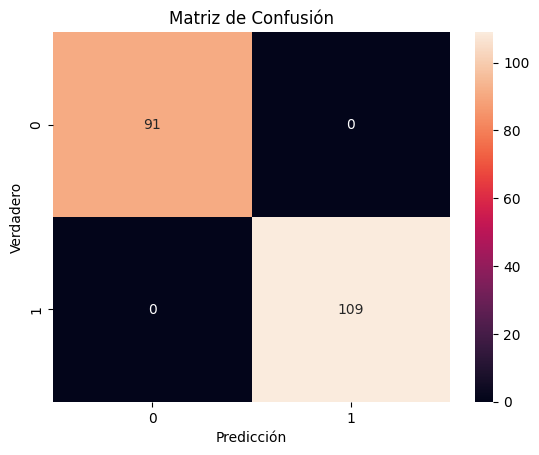

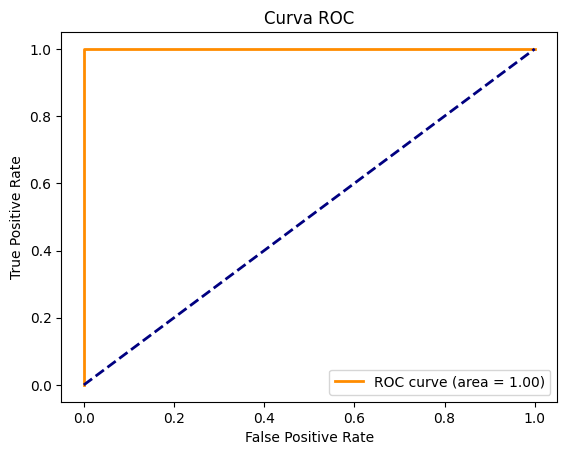

In [94]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generación de la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matriz de Confusión")
plt.ylabel("Verdadero")
plt.xlabel("Predicción")
plt.show()

# Calcula los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_pca)[:,1])
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


Análisis de curvas de luz

In [9]:
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import lightkurve as lk
import numpy as np

# Let's look at a star we know has a planet
*If we can spot a blob periodically transiting between the star and us, chances are it's an exoplanet*


<Axes: title={'center': 'Target ID: 6922244, Cadence: 11958'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

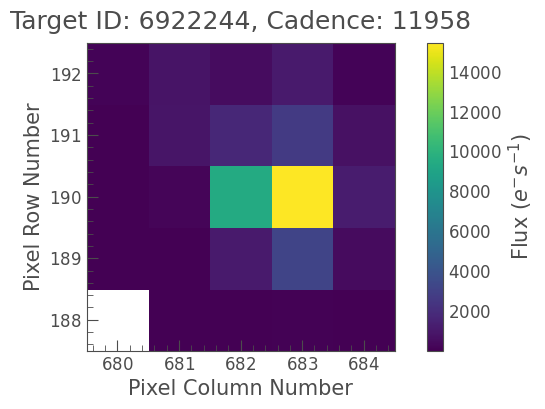

In [10]:
# Download the pixelfile for a given star
# A quarter means a quarter of a year
pixelFile = search_targetpixelfile('KIC 6922244', author="Kepler", cadence="long", quarter=4).download()
# Show a single snapshot
pixelFile.plot(frame=42)


3.522652265226523 d
353.60132485035285
0.1 d


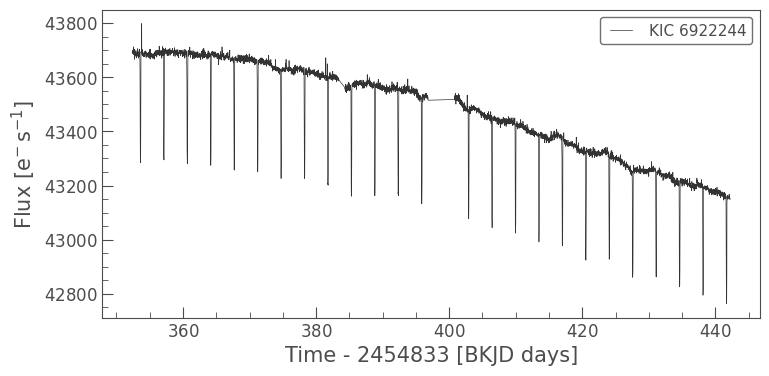

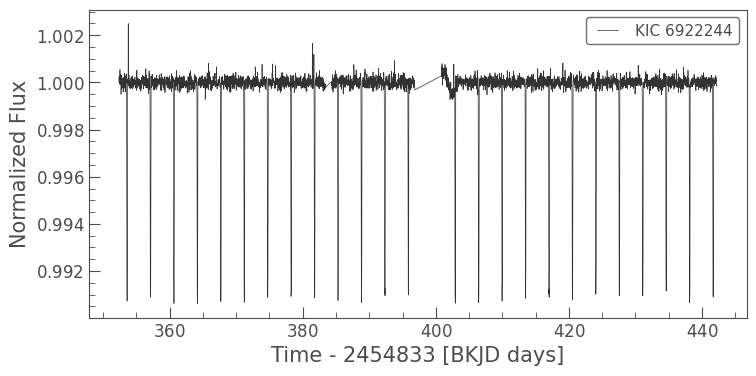

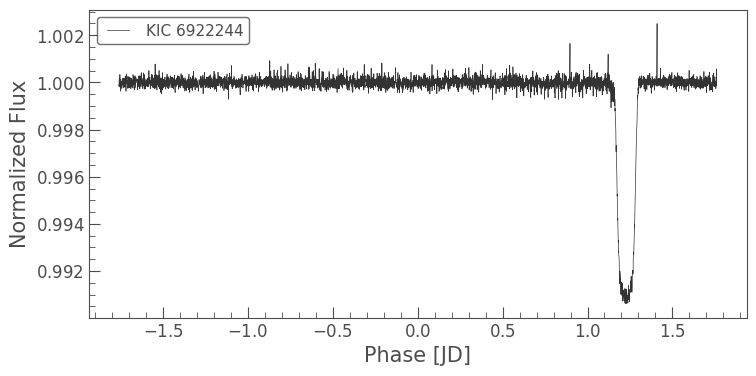

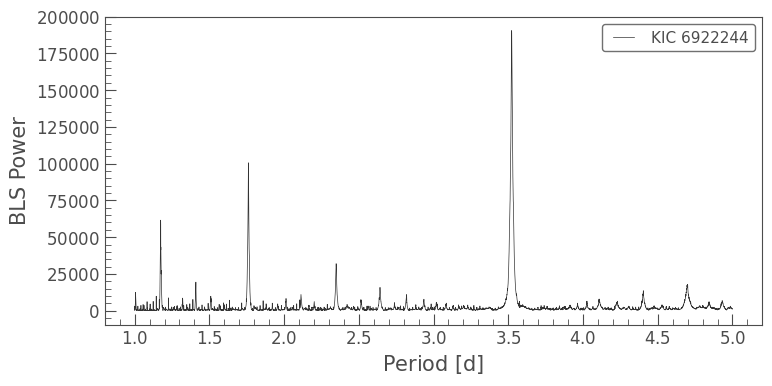

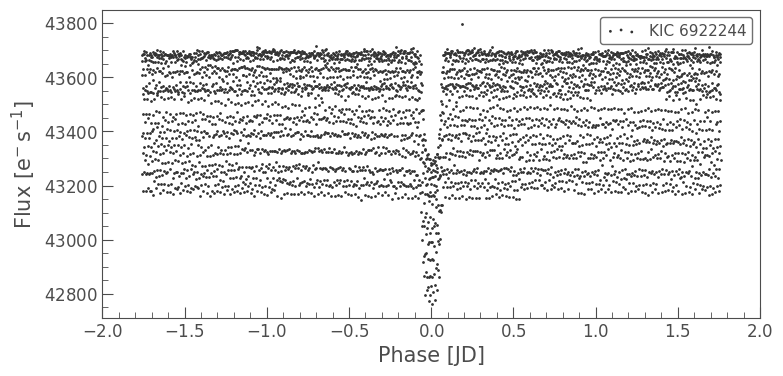

In [11]:
# We'll combine the individual frames into a lightcurve
# Aperture masks make the image look better for analysis
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
lc.plot()

# We may find it easier to spot the pattern if we flatten the curve
flat_lc = lc.flatten()
flat_lc.plot()

# Phase-fold the light curve to verify that the period and transit time
# correspond to the transit signal
# This puts the frequency spikes on top of each other if we get the period right
folded_lc = flat_lc.fold(period=3.5225)
folded_lc.plot()

# How to discover the correct period?
# Use a periodogram to show all the repetitive patterns in your graph
# Gives you the most likely candidate

# Periodograms are an estimate of the spectral density of a signal
# (An estimation of what the Fourier Transform of the data would look like
#  if it were a continuous function https://arxiv.org/pdf/1703.09824.pdf)

period = np.linspace(1, 5, 10000)
# BLS = Box Least Squares
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

# Period value corresponding to the highest peak in the periodogram
planet_x_period = bls.period_at_max_power

planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power

# Folding can yield a lot of information about the planet
# The depth can tell you about the size, etc
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-2,2)

print(planet_x_period)
print(planet_x_t0)
print(planet_x_dur)


In [102]:
(lc.flux[3114:-2]/43330).reshape(1, -1)

<Quantity [[0.99986434, 1.000116  , 1.0002604 , 0.9997588 , 0.9996413 ,
            1.0000242 , 0.9998169 , 0.99984825, 0.99970853, 0.99970555,
            0.99978274, 0.9999681 , 0.99938536, 0.99985784, 1.0001314 ,
            0.9996201 , 0.9996613 , 0.99994814, 0.99980223, 0.9995175 ,
            0.99963886, 0.9997319 , 0.999759  , 0.9997421 , 0.9996631 ,
            0.999882  , 0.9995724 , 0.9994653 , 0.9998417 , 0.9998311 ,
            0.99959576, 0.9994975 , 0.99980456, 0.9999056 , 0.9997609 ,
            0.9998079 , 0.9996317 , 0.99951357, 0.99993616, 0.99988157,
            0.9996959 , 0.9997787 , 0.99999124, 0.9998179 , 0.9997308 ,
            0.9999309 , 0.9995952 , 0.99974245, 0.99951965, 0.9996447 ,
            0.99981004, 0.999527  , 0.99962246, 0.99983865, 0.9995089 ,
            0.9995542 , 0.9996238 , 0.9996914 , 0.9997931 , 0.9996825 ,
            0.9996524 , 0.99978274, 0.9996707 , 0.9997103 , 0.99973804,
            0.99999034, 0.99981445, 1.0000178 , 0.9995631 , 1.00

In [103]:
signal = (lc.flux[3114:-2]/43330).reshape(1, -1)
# Apply PCA transformation
signal_pca = pca.transform(signal)
# Use the model to predict
prediction = model.predict(signal_pca)
print(f"The predicted class is: {prediction[0]}")

The predicted class is: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


# Let's try and find a planet!
*Pick a star and try to see if there's something transiting in front of it*

## Selecting a star

In [12]:
# Use TESS data. That's being updated regularly. Kepler is already well analysed

# Downloading MAST data
# https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

# Look for nearby stars
# MAST catalogs -> TESS CTL v8.01 -> Advanced Search
# Has 9.5 million records

# Narrow down the search as you like

# For example:
# T_eff = Temperature between 2000 and 3500
#         These are red dwarfs and tend to have rapidly orbiting planets
#         Which fits the 24 day time sampling rate of TESS

# Distance = Between 12 and 24 parsecs
#            Because we are not able to do the Kessel run in less than 12

# Take the ID, e.g. 140206488

# Double-check in EXOMAST to see if a planet has already been found

# Put the name in MAST search and find TESS data
# We can try to access this with search_targetpixelfile
# OR download the data to a local folder

# Analyze the star

(-3.0, 3.0)

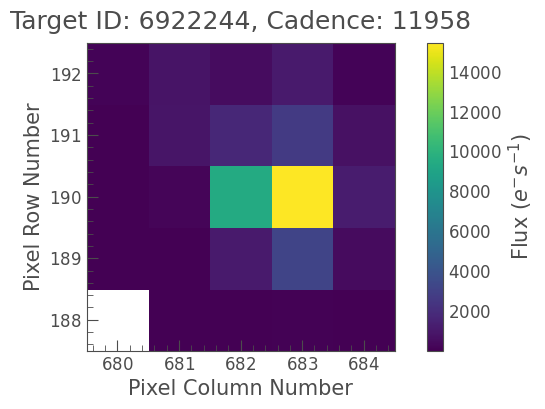

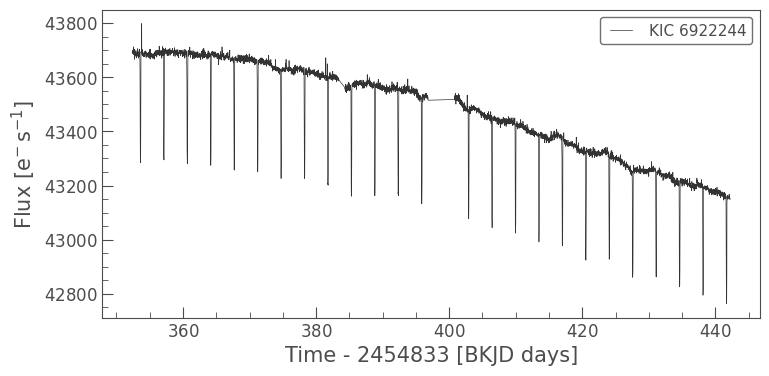

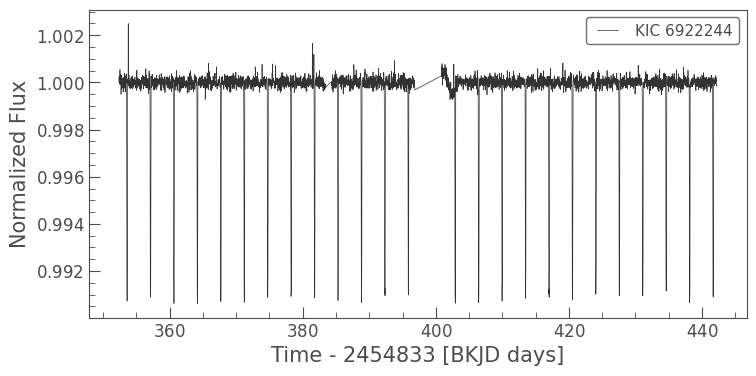

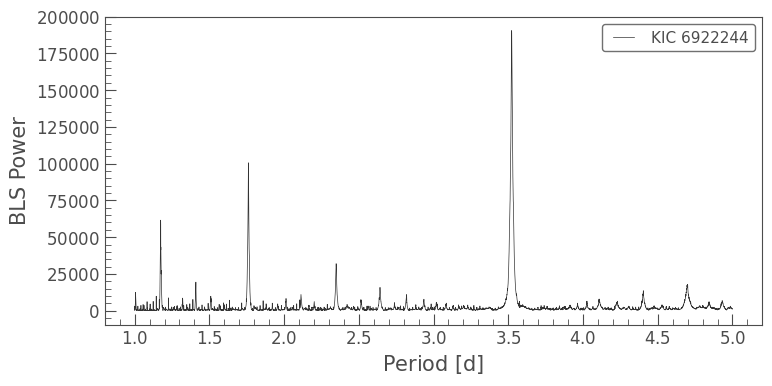

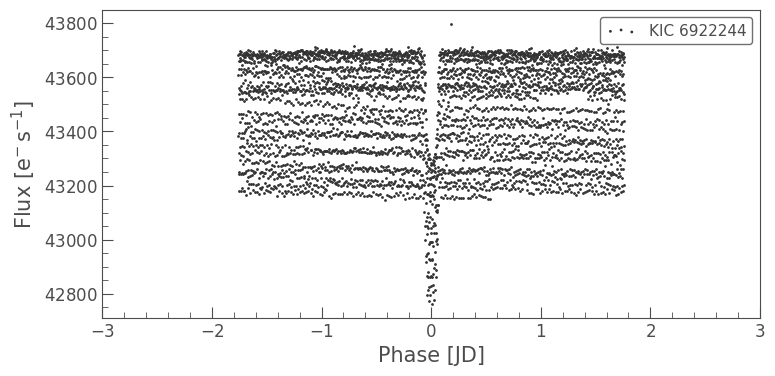

In [72]:
# Let's download the pixelfile for a given star
# And save it to a local folder (See download helper below)

# Command to search for file - often is not available, so that's why we download more manually
pixelFile = search_targetpixelfile('KIC 6922244', author="Kepler", cadence="long", quarter=4).download()
tpf = pixelFile
# tpf = TessTargetPixelFile("/TESS/MAST_2024-01-07T2147/TESS/tess2019357164649-s0020-0000000309661100-0165-s/tess2019357164649-s0020-0000000309661100-0165-s_tp.fits")
# Show a single snapshot
tpf.plot(frame=42)

# Plot the lightcurve
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

# Flatten it
flat_lc = lc.flatten()
flat_lc.plot()

# Try and find the period of the most prominent orbiting object
period = np.linspace(1, 5, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

planet_x_period = bls.period_at_max_power
planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power

# Phase-fold the ligthcurve based on the discovered period at max power
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-3,3)

Segundo Método

In [16]:
from lightkurve import search_targetpixelfile
pixelfile = search_targetpixelfile("KIC 8462852", quarter=16).download(quality_bitmask='hardest')

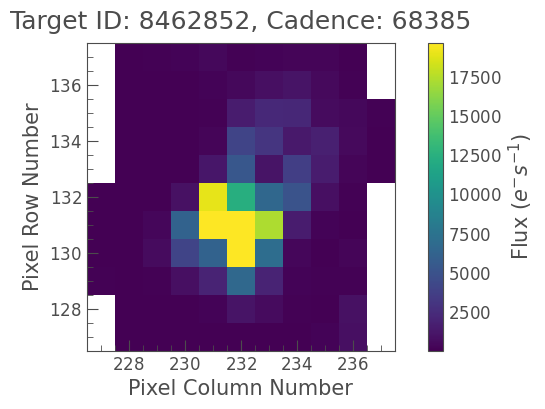

In [17]:
pixelfile.plot(frame=1000);

In [18]:
lc = pixelfile.to_lightcurve(aperture_mask='all')
lc.time, lc.flux

(<Time object: scale='tdb' format='bkjd' value=[1472.11777934 1472.13821223 1472.15864492 ... 1557.89718798 1557.9380561
  1557.95849016]>,
 <Quantity [258645.03, 258660.05, 258690.08, ..., 258929.86, 258884.66,
            258865.6 ] electron / s>)

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

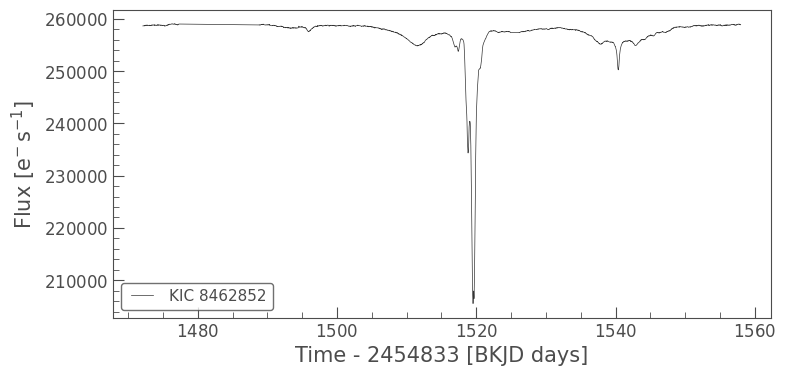

In [19]:
lc.plot()

In [20]:
pixelFile = search_targetpixelfile('KIC 6922244', quarter=4).download()

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

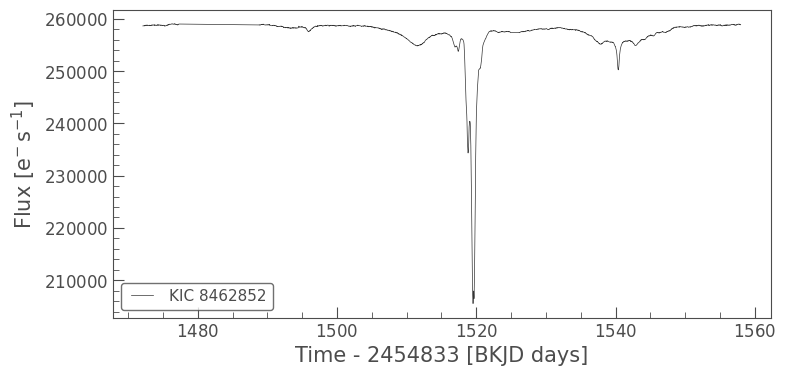

In [21]:
lc.plot()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

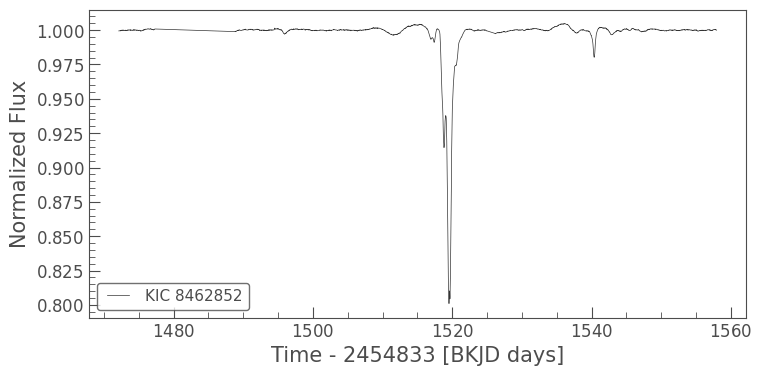

In [22]:
flat_lc = lc.flatten(window_length=401)
flat_lc.plot()

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

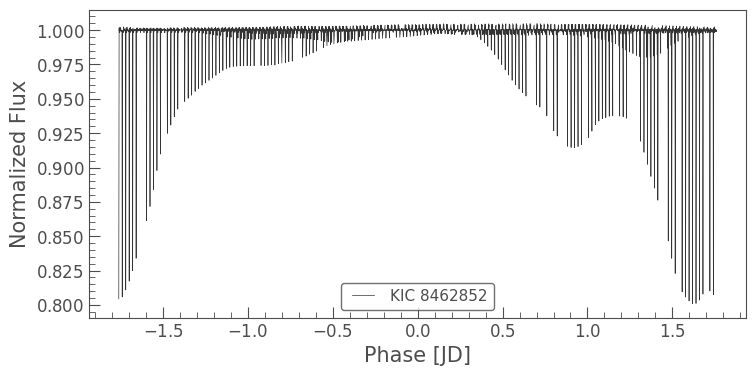

In [23]:
folded_lc = flat_lc.fold(period=3.522)
folded_lc.plot()

<ipython-input-24-bd0214550cce>:1: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  binned_lc = folded_lc.bin(binsize=10)


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

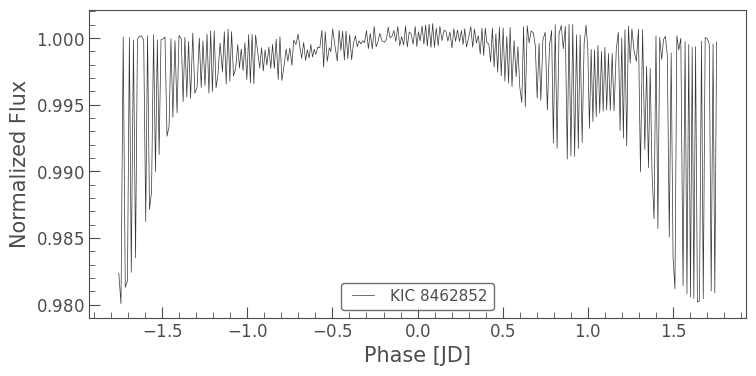

In [24]:
binned_lc = folded_lc.bin(binsize=10)
binned_lc.plot()

<ipython-input-25-23298bdcb5c7>:1: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  lc.remove_nans().flatten(window_length=401).fold(period=3.5225).bin(binsize=10).plot()


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

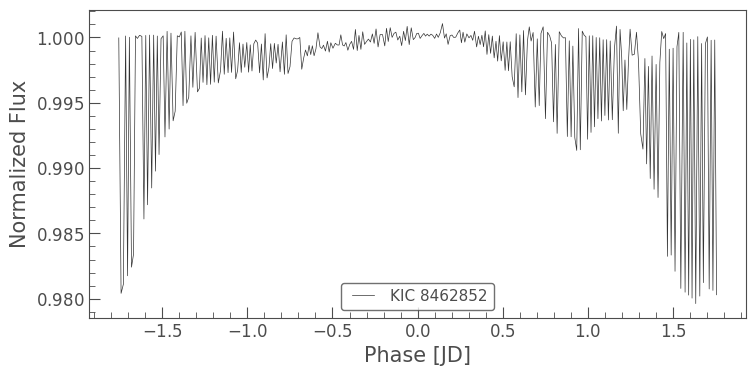

In [25]:
lc.remove_nans().flatten(window_length=401).fold(period=3.5225).bin(binsize=10).plot()

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

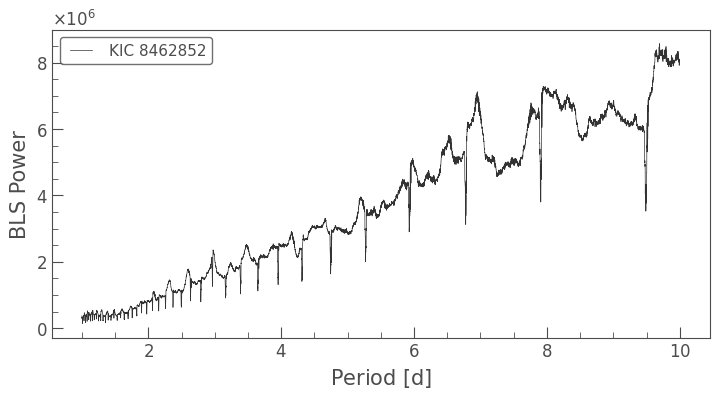

In [26]:
import numpy as np
periodogram = flat_lc.to_periodogram(method="bls", period=np.arange(1, 10, 0.001))
periodogram.plot()

In [27]:
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.5f}'.format(best_fit_period))

Best fit period: 9.69400 d


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

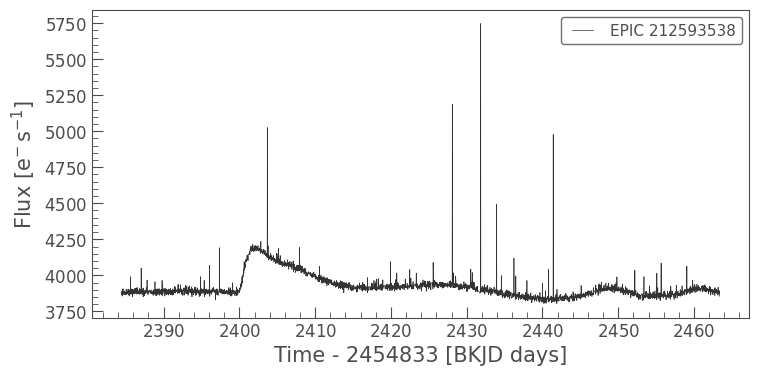

In [28]:
tpf = search_targetpixelfile('EPIC 212593538', campaign=6).download()
lc = tpf.to_lightcurve(aperture_mask='all')
lc.plot()

In [29]:
from lightkurve import search_targetpixelfile
search_result = lk.search_targetpixelfile('Pi Mensae', mission='TESS', sector=1)
tpf = search_result.download(quality_bitmask='default')

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [30]:
tpf.mission
tpf.targetid

261136679

<Axes: title={'center': 'Target ID: 261136679, Cadence: 70445'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

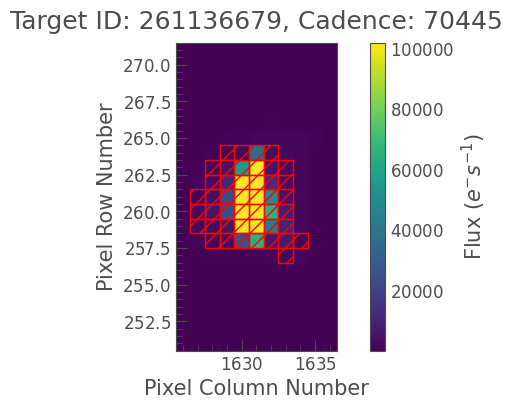

In [31]:
tpf.plot(aperture_mask=tpf.pipeline_mask)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

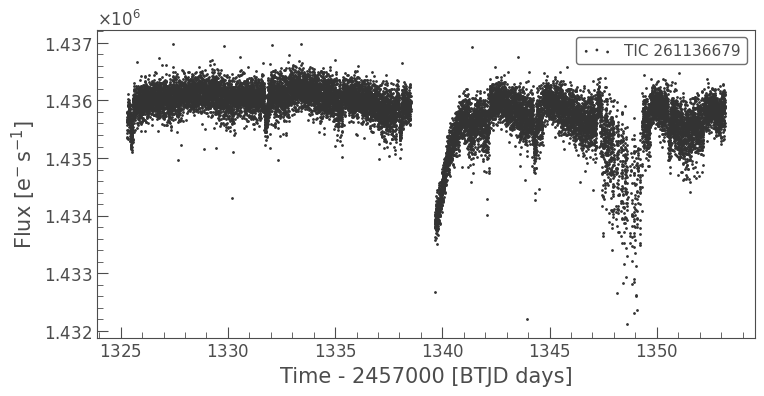

In [32]:
lc = tpf.to_lightcurve()
lc.scatter()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

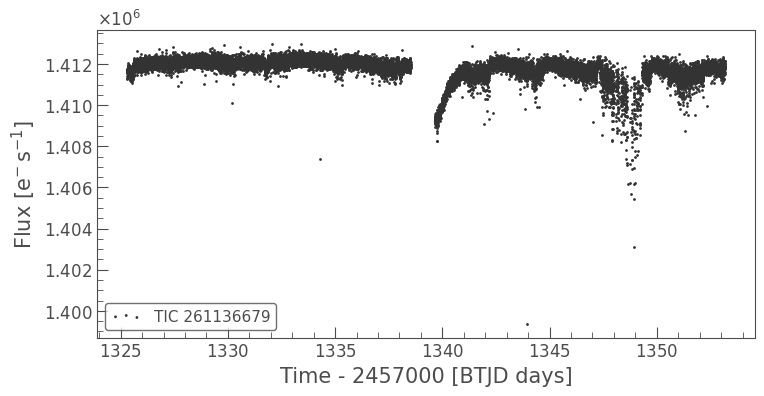

In [33]:
aperture_mask = tpf.create_threshold_mask(threshold=10)
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc.scatter()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

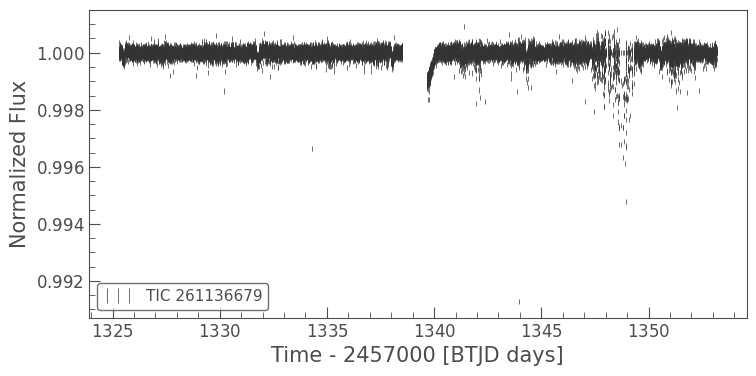

In [34]:
flat_lc = lc.flatten(window_length=1001)
flat_lc.errorbar()

In [35]:
flat_lc.time.value

array([1325.2969605 , 1325.29834936, 1325.29973823, ..., 1353.17428819,
       1353.17567704, 1353.1770659 ])

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

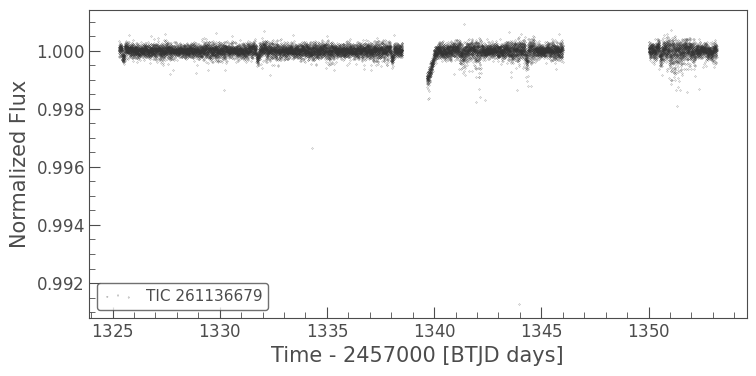

In [36]:
mask = (flat_lc.time.value < 1346) | (flat_lc.time.value > 1350)
masked_lc = flat_lc[mask]
masked_lc.scatter(s=0.1)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

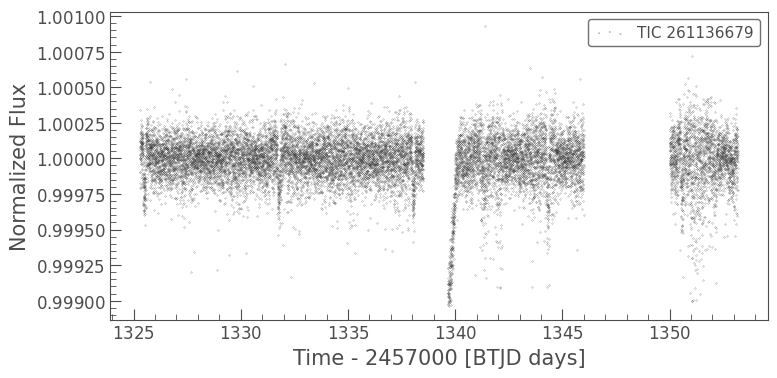

In [37]:
clipped_lc = masked_lc.remove_outliers(sigma=6)
clipped_lc.scatter(s=0.1)

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

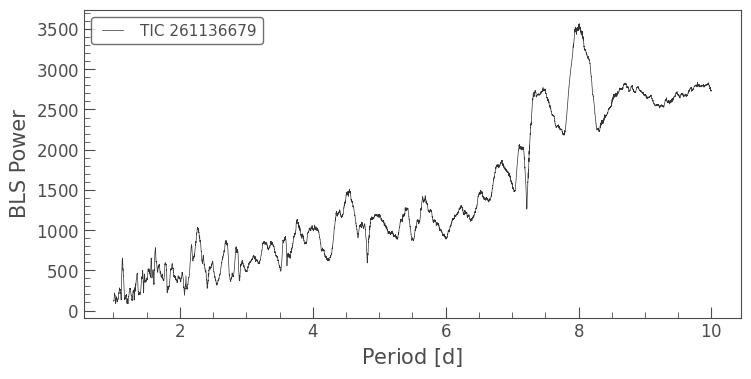

In [38]:
import numpy as np
periodogram = clipped_lc.to_periodogram(method="bls", period=np.arange(1, 10, 0.001))
periodogram.plot()

In [39]:
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.3f}'.format(best_fit_period))

Best fit period: 8.010 d


/usr/local/lib/python3.10/dist-packages/astropy/utils/decorators.py:604: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

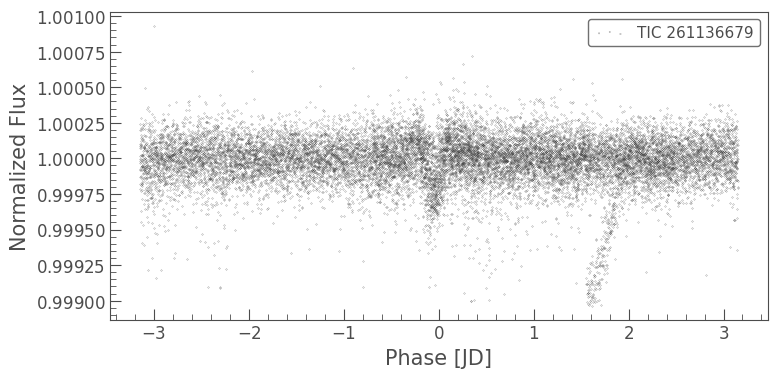

In [69]:
folded_lc = clipped_lc.fold(period=6.30, t0=1325.504)
folded_lc.scatter(s=0.1)

<ipython-input-70-7a0d2c90d665>:1: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  binned_lc = folded_lc.bin(binsize=10)


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

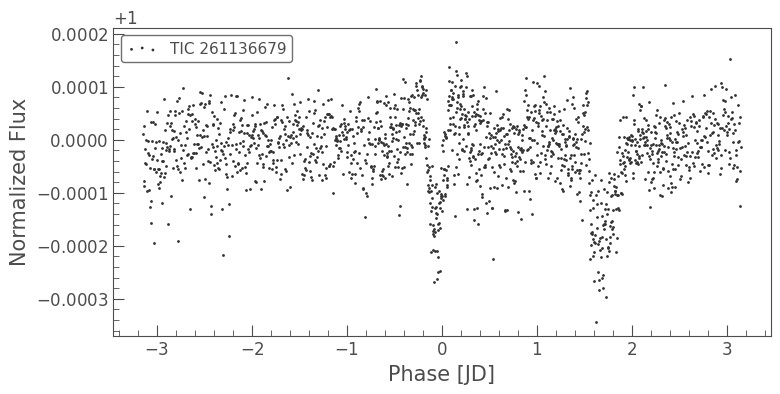

In [70]:
binned_lc = folded_lc.bin(binsize=10)
binned_lc.scatter()

In [104]:
binned_lc.flux[613:-2].reshape(1, -1)

<Quantity [[0.99999468, 0.99997728, 0.99991631, 0.99998476, 1.00002732,
            1.00004215, 1.00007619, 1.00005439, 0.99999345, 1.00007235,
            1.00001194, 0.99997329, 1.00005924, 1.00008233, 0.99995466,
            0.99999035, 0.99997286, 0.99998742, 1.00008526, 1.00005866,
            1.00003786, 1.00001187, 1.00008012, 1.00001745, 1.00005702,
            1.0000273 , 1.0000571 , 1.00003409, 1.00005058, 1.00010207,
            1.00010782, 1.0000944 , 0.99999338, 1.00005044, 1.00004133,
            1.00008491, 1.00005775, 1.00002968, 0.999994  , 1.00003584,
            1.00011219, 1.00011151, 1.00012047, 1.00004294, 1.00008126,
            1.00008405, 1.00010252, 1.00009922, 1.00003787, 1.00009507,
            1.00008842, 1.00002595, 1.00000398, 1.0000083 , 0.99999434,
            1.00000154, 1.00008535, 0.99999037, 1.00000622, 0.99998575,
            0.99996595, 1.00002199, 1.00001564, 1.0000939 , 1.00007776,
            0.99993899, 0.9999527 , 0.9999031 , 0.99994255, 0.99

In [71]:
signal = binned_lc.flux[613:-2].reshape(1, -1)
# Apply PCA transformation
signal_pca = pca.transform(signal)
# Use the model to predict
prediction = model.predict(signal_pca)
print(f"The predicted class is: {prediction[0]}")


The predicted class is: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
